In [23]:
import numpy as np
import matplotlib.pyplot as plt

import random

import sklearn
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import re

import json

import spacy

nlp = spacy.load("en_core_web_trf")

# nltk.download('punkt')
# nltk.download("stopwords")
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')


In [24]:
file = open("json_data.json")

allprompts = json.load(file)

In [25]:
numPrompts = []
prompt_corpus = []

for college in allprompts:
    numPrompts.append(len(college[1]))

    for prompt in college[1]:
        if len(prompt[1]) > 0 and len(prompt[1][0]) > 0:
            prompt_corpus.append(prompt[1])

In [26]:
prompt_vectors = []
prompt_indices = []
i = 0

for doc in nlp.pipe(prompt_corpus):
    transformed_prompt = doc._.trf_data.tensors[-1]
    if transformed_prompt.shape == (1,768):
        prompt_vectors.append(transformed_prompt[0])
        prompt_indices.append(i)
    i += 1

prompt_matrix = np.stack(prompt_vectors, axis=0)


C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [27]:
print(prompt_matrix.shape)

prompt_matrix_indexed = np.hstack((np.array(prompt_indices)[:,None], prompt_matrix))

(941, 768)


In [28]:
prompt_matrix_indexed.shape

(941, 769)

In [29]:
def indToDict(index):
    numPrompts = []
    for prompts in allprompts:
        numPrompts.append(len(prompts[1]))
    
    total = 0
    for x in range(len(numPrompts)):
        curr = numPrompts[x]

        if (total + curr) > index:
            ind = index - total
            return (x, int(ind))
        
        total += curr

In [30]:
indToDict(943)

(299, 1)

In [31]:
pca = PCA(n_components=4)

pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

pca_data = np.hstack((np.arange(pca_data.shape[0])[:, None], pca_data))

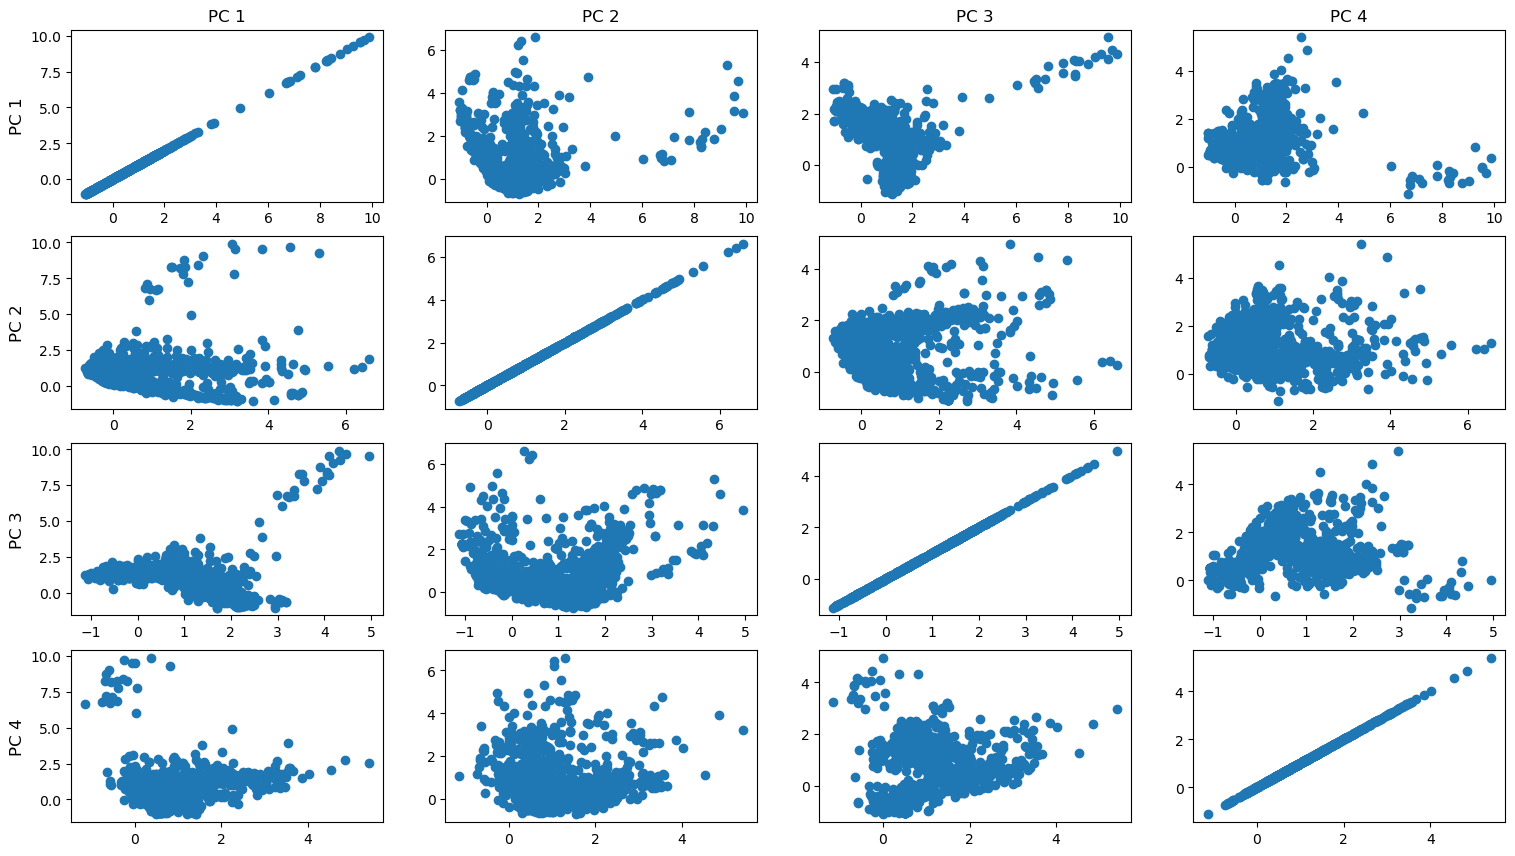

In [32]:
num_comps = pca_data.shape[1]-1

fig, axs = plt.subplots(num_comps, num_comps)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps+1):
    for j in range(1, num_comps+1):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1)
        if i == 1:
            axs[i-1][j-1].set_title("PC " + str(j))
        if j == 1:
            axs[i-1][j-1].set_ylabel("PC " + str(i), fontsize = "large")

plt.show()

In [33]:
pca = PCA(n_components=100)

pca_data = pca.fit_transform(prompt_matrix_indexed[:,1:])

pca_data = np.hstack((np.arange(pca_data.shape[0])[:, None], pca_data))

29


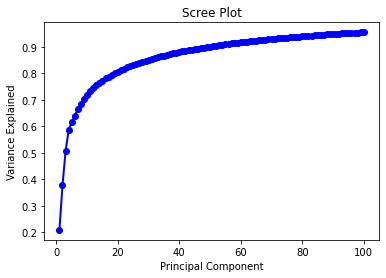

In [34]:
PC_values = np.arange(pca.n_components_) + 1

cumulative_var = [sum(pca.explained_variance_ratio_[0:x+1]) for x in range(len(pca.explained_variance_ratio_))]

i=0
for x in cumulative_var:
    if x > 0.85:
        print(i)
        break
    i+=1
        

plt.plot(PC_values, cumulative_var, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [35]:
print(sum(pca.explained_variance_ratio_))

0.955293799732787


In [36]:
# k-means for any dim, points is list of vectors in n-dim

def select_init(points, k, labels):
    random.seed = (333)

    dist_weights = []
    centroids = []

    centroids.append(np.asarray(random.choice(points)))

    while len(centroids) < k:
        dist_weights = find_distances(points, centroids, labels)
        centroids.append(np.asarray(random.choices(points, weights=dist_weights)[0]))

    return centroids


def find_distances(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]
    closest_dists = []

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            
            if curr_dist < min_dist:
                min_dist = curr_dist
        
        closest_dists.append(min_dist)
        
    return closest_dists


def find_clusters(points, centroids, labels = 0):
    clusters = [[] for x in range(len(centroids))]

    for curr_point in points:

        # should be large enough given that words will rarely 
        #   occur more than even 20 times in one prompt
        min_dist = 100000000
        min_ind = len(centroids)
        for j in range(len(centroids)):
            curr_dist = sum((centroids[j][labels:] - curr_point[labels:]) ** 2) ** 0.5
            if curr_dist < min_dist:
                min_dist = curr_dist
                min_ind = j
        
        clusters[min_ind].append(curr_point)

    return clusters


def k_means(points, k, labels = 0):

    print(labels)

    centroids = select_init(points, k, labels)


    for center_num in range(k):
        centroids[center_num] = np.asarray(centroids[center_num])
    
    equal_means = 0
    clusters = []

    while equal_means < k:
        clusters = find_clusters(points, centroids, labels)
        
        for i in range(k):
            mean = sum(np.asarray(clusters[i])) / len(clusters[i])

            dim = labels
            curr_equal_means = True
            while (dim < len(points[0])) and curr_equal_means:
                if (mean[dim] != centroids[i][dim]):
                    centroids[i] = mean
                    curr_equal_means = False
                dim += 1
            
            if dim == len(points[0]):
                equal_means += 1
    
    return clusters

1
36


Text(0.5, 1.0, 'PC 1 vs PC 2 with 2D KMeans clusters')

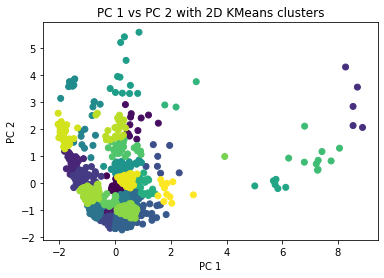

In [39]:
pca_points = [list(pca_data[i,0:3]) for i in range(len(pca_data[:,1]))]

num_clusters = 30

pca_clusters = k_means(pca_points, num_clusters, labels = 1)

print(len(pca_clusters[0]))

pca_clusters_graph = []

for c in range(len(pca_clusters)):
    for x in pca_clusters[c]:
        pca_clusters_graph.append(x + [c])

pca_clusters_graph = np.asarray(pca_clusters_graph)

plt.scatter(pca_clusters_graph[:,1], pca_clusters_graph[:,2], c = pca_clusters_graph[:,3])
plt.xlabel("PC 1") 
plt.ylabel("PC 2")
plt.title("PC 1 vs PC 2 with 2D KMeans clusters")

In [40]:
n = 2
print(len(pca_clusters[n]))
for point in pca_clusters[n]:
    r, c = indToDict(point[0])

    print(allprompts[int(r)][1][int(c)])

41
['Overcoming Challenges Short Response', 'Tell us about the most significant challenge you’ve faced or something important that didn’t go according to plan. How did you manage the situation?']
['Huntsman Program Essay', 'The Huntsman Program supports the development of globally-minded scholars who become engaged citizens, creative innovators, and ethical leaders in the public, private, and non-profit sectors in the United States and internationally. What draws you to a dual-degree in business and international studies, and how would you use what you learn to make a contribution to a global issue where business and international affairs intersect?']
['Additional Info Short Response', 'Tell us about how you have collaborated with and worked together within a small group of your peers on some task or endeavor in the past, or about how you imagine you will work with your Caltech peers in the future.']
['Select-A-Prompt', 'Tell us the story of a specific time when you made someone happy.

In [41]:
# using sklearn KMeans function
elbow = []

for i in range(1, 50):
    kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 333)
    kmeans.fit(prompt_matrix_indexed[:,1:])
    elbow.append(kmeans.inertia_)

C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Text(0.5, 1.0, 'KMeans Elbow Plot')

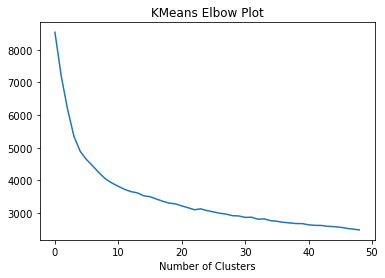

In [43]:
plt.plot(elbow)
plt.xlabel("Number of Clusters")
plt.ylabel("")
plt.title("KMeans Elbow Plot")

In [44]:
kmeans = KMeans(n_clusters = 50, init = "k-means++", random_state = 333)

kmeans.fit(prompt_matrix_indexed[:,1:])

KMeans(n_clusters=50, random_state=333)

Text(0.5, 1.0, 'PC 1 vs PC 2 plot with multidimensional KMeans clusters')

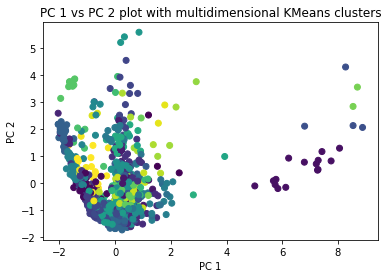

In [46]:
kmeans.labels_.shape

plt.scatter(pca_data[:,1], pca_data[:,2], c = kmeans.labels_)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PC 1 vs PC 2 plot with multidimensional KMeans clusters")

In [47]:
n = 1

count = 0
for p in range(len(kmeans.labels_)):
    if int(kmeans.labels_[p]) == n:
        r, c = indToDict(p)

        print(allprompts[int(r)][1][int(c)])
        count += 1

print(count)



['Why This College Essay', 'Please share with us why you consider Duke a good match for you. Is there something in particular about Duke’s academic or other offerings that attracts you? ']
[' Nursing and Healthcare Management Essay', " Discuss your interest in nursing and health care management. How might Penn's coordinated dual-degree program in nursing and business help you meet your goals?"]
['Bio-dental Program Short Response', 'What activities have you performed that demonstrate your ability to work cooperatively with people?']
['Select-A-Prompt', 'For you, what makes Cornell Engineering special? Why do you want to attend Cornell Engineering?']
['Why This Major Essay', 'What academic areas are you interested in exploring in college?']
['Social Work Majors Essay', 'Discuss the reasons you chose Social Work as your first-choice major and how a Social Work degree from UT will prepare you for the future.']
['Why This Major Short Response', 'Please explain your interest in your first-c

In [48]:
all_clusters = k_means(prompt_matrix_indexed, 50, labels = 1)

for x in all_clusters:
    print(len(x))

1
8
28
26
1
21
13
68
39
84
1
29
28
8
12
43
11
6
39
1
9
31
8
49
4
2
8
20
8
2
8
12
34
1
4
18
48
16
7
4
9
51
6
5
10
19
16
46
11
1
8


In [53]:
n = 1
for x in all_clusters[n:n+1]:
    print(len(x))

    for i in range(0, len(x)):
        r, c = indToDict(x[i][0])

        print(allprompts[int(r)][1][int(c)])

28
['Why This College Essay', 'What is it about Yale that has led you to apply?']
['Select-A-Prompt', 'What brings you joy? ']
['Select-A-Prompt', 'What excites you?']
['ISP Program Essay', 'How did you learn about ISP?']
['Select-A-Prompt', 'What would you fight for?']
['Why This College Short Response', 'Why do you want to attend CMC?']
['TV Show Short Response', 'What TV show will you binge watch next?']
['Why This College Essay', 'How did you first learn about Lehigh University and what motivated you to apply?']
['Why This College Short Response', 'Why have you chosen to apply to Scripps College?']
['Why This Major Short Response', 'Why do you want to study your chosen major specifically at Georgia Tech?']
['Why This College Short Response', 'What excites you about St. Olaf?']
['Science BS/MBA Short Response', 'Why do you want to attend Penn State?']
['Happiness Short Answer', 'What makes you happy?']
['Why This College Short Response', 'Please tell us why you want to attend UMass 

In [50]:
import hdbscan

cluster_obj = hdbscan.HDBSCAN(min_cluster_size=5, min_samples = 1)

# cluster_obj = hdbscan.HDBSCAN()

cluster_obj.fit(prompt_matrix)

HDBSCAN(min_samples=1)

In [51]:
print(sum([x for x in cluster_obj.labels_ if x == -1]))
print(max(cluster_obj.labels_[0:10]))

-553
19


C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\viche\miniconda3\envs\scikit\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'tSNE plot colored by HDBSCAN clusters')

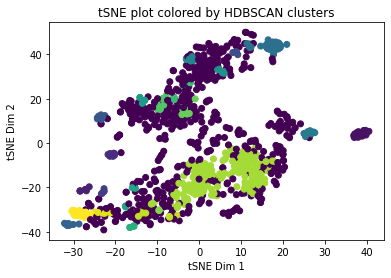

In [54]:
np.random.seed(333)

projection = sklearn.manifold.TSNE().fit_transform(prompt_matrix)
plt.scatter(*projection.T, c=cluster_obj.labels_)

plt.xlabel("tSNE Dim 1")
plt.ylabel("tSNE Dim 2")
plt.title("tSNE plot colored by HDBSCAN clusters")

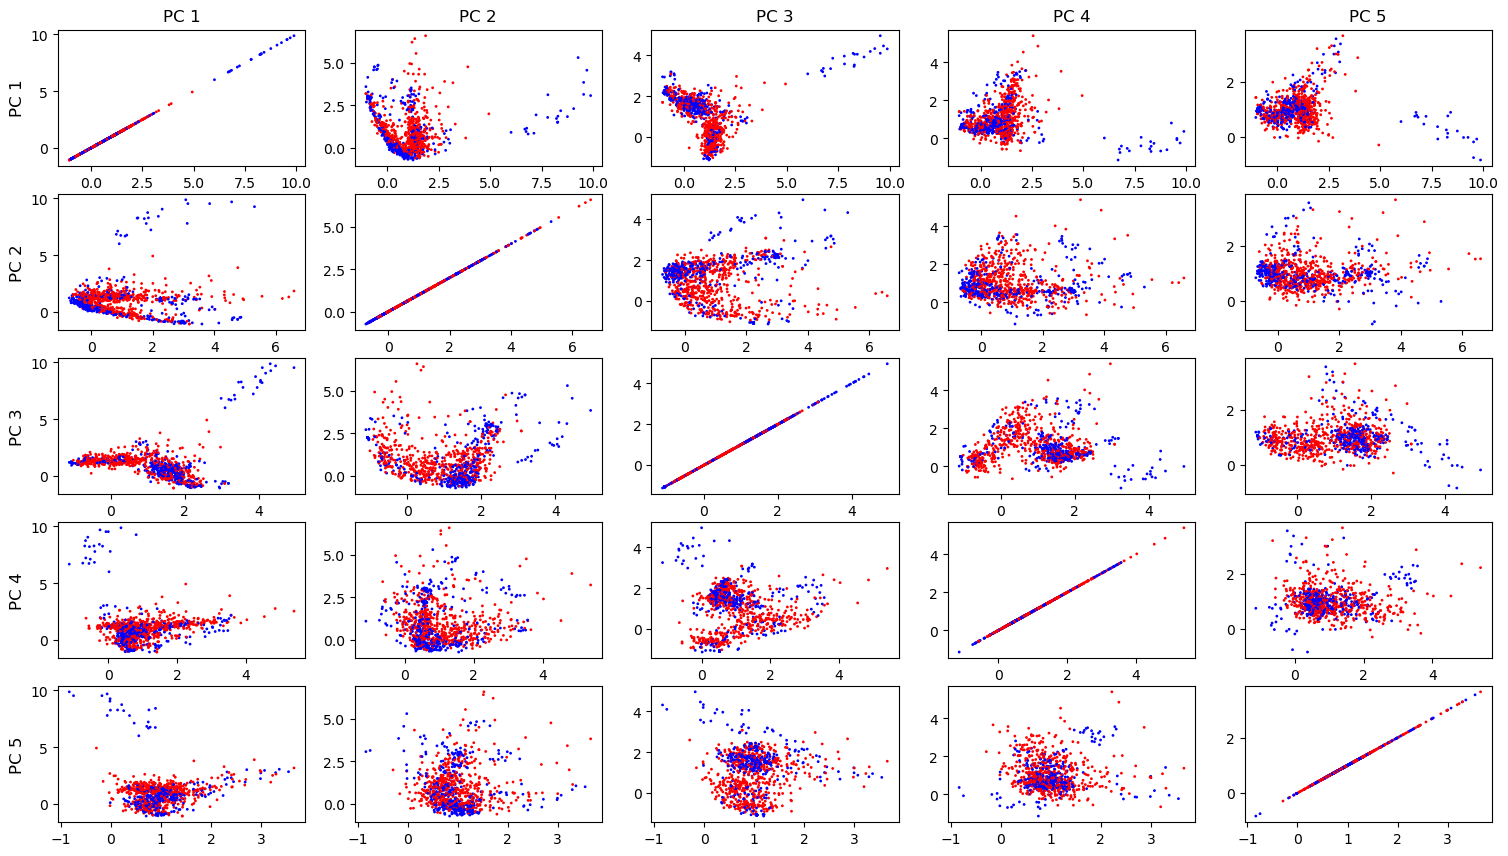

In [55]:
num_comps = 6

fig, axs = plt.subplots(num_comps-1, num_comps-1)

fig.set_size_inches(18.5, 10.5, forward=True)

fig.set_dpi(100)

for i in range(1, num_comps):
    for j in range(1, num_comps):
        axs[i-1][j-1].scatter(pca_data[:,i]+1, pca_data[:,j]+1, c = ["red" if x < 0 else "blue" for x in cluster_obj.labels_], s=[1 if x < 0 else 1 for x in cluster_obj.labels_])
        if i == 1:
            axs[i-1][j-1].set_title("PC " + str(j))
        if j == 1:
            axs[i-1][j-1].set_ylabel("PC " + str(i), fontsize = "large")